# Notebook for the decision tree task

In [8]:
# imports

import matplotlib.pyplot as plt
import numpy as np

# Import Pandas and NumPy functionality for editing data
import pandas as pd
import seaborn as sns

# Importing IPython display for visualizing intermediate results in the notebook
from IPython.display import display

# decision tree
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

Load the train and test data sets

In [9]:
train_dataset_oh = pd.read_csv('./train_insurance_one_hot.csv')
x_train = train_dataset_oh.drop(columns=['id','charges','chargeGroup'], inplace=False)
y_train = train_dataset_oh[["chargeGroup"]]

test_dataset_oh = pd.read_csv('./test_insurance_one_hot.csv')
x_test = test_dataset_oh.drop(columns=['id','charges','chargeGroup'], inplace=False)
y_test = test_dataset_oh[["chargeGroup"]]

In [10]:
def accuracy(target: np.ndarray, predicted: np.ndarray) -> float:
    if not isinstance(target, np.ndarray):
        np.array(target)
    assert len(target) == len(predicted)
    return (target == predicted).sum()/len(target)

## a) wishful-thinking model

In [11]:
# Simple define the model
class wishful_thinking_model:
    def predict(self, data):
        return np.array(['low' for _ in range(len(data.index))], dtype='str')

model_0 = wishful_thinking_model()
prediction_0 = model_0.predict(x_test)
print(f"Accuracy of wishful-thinking model: {100*accuracy(y_test['chargeGroup'],prediction_0):.2f}%")

Accuracy of wishful-thinking model: 48.88%


## b) mode-based model

In [12]:
# Simple define the model
class mode_based_model:
    mode = None
    def fit(self, data, target_feature_key: str = 'chargeGroup'):
        self.mode = data[target_feature_key].mode()[0]
    def predict(self, data):
        return np.array([self.mode for _ in range(len(data.index))], dtype='str')

model_1 = mode_based_model()
model_1.fit(y_train,'chargeGroup')
prediction_1 = model_1.predict(x_test)
print(f"mode of training data: {model_1.mode}")
print(f"Accuracy of mode-based model: {100*accuracy(y_test['chargeGroup'],prediction_1):.2f}%")

mode of training data: medium
Accuracy of mode-based model: 38.81%


## c) Decision Tree with sklearn

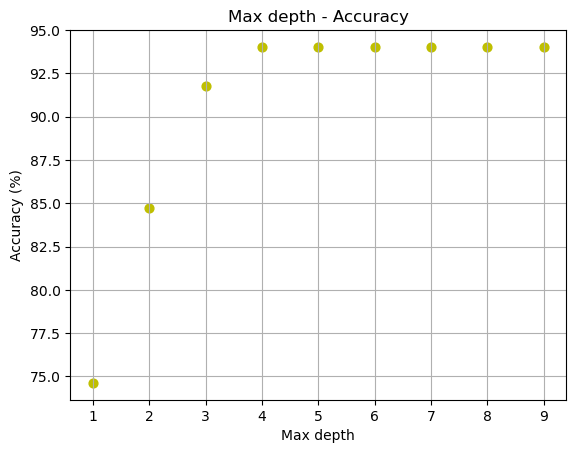

In [13]:
# Check data for unwanted features
unwanted = {'charges', 'chargeGroup', 'id'}
assert all(feat not in set(x_train.columns) for feat in unwanted)

# Common configuration
basic_setting = dict(criterion="entropy", min_samples_leaf=6, random_state=42)

# Helpers to plot
def plot(xs,ys):
    plt.scatter(xs, ys, color = "y", marker = "o", s = 40)
    plt.xlabel('Max depth') 
    plt.ylabel('Accuracy (%)')
    plt.title('Max depth - Accuracy')
    plt.grid(True)
    plt.savefig("maxdepth_vs_acc.png")
    plt.show();

accuracies = []
depths = [*range(1,10)]
for depth in depths:
    model = tree.DecisionTreeClassifier(max_depth=depth, **basic_setting)
    model.fit(x_train, y_train)
    accuracies.append(100*accuracy(y_test['chargeGroup'], model.predict(x_test)))

plot(depths, accuracies)

## d) Create and Visualize DT with different params

In [14]:
# Helpers to get new data entry in one-hot encoded format
import re
def detect_one_hot_groups(df):
    groups = {}
    for col in df.columns:
        match = re.match(r"(.*)_(.*)", col)
        if match:
            prefix, category = match.groups()
            groups.setdefault(prefix, []).append((category, col))
    return groups

def encode_new_row(raw_entry, df_encoded):
    groups = detect_one_hot_groups(df_encoded)
    new_row = {col: [False] for col in df_encoded.columns}  # start with all False
    
    # copy numeric fields
    for k, v in raw_entry.items():
        if k not in groups:
            new_row[k] = [v]

    # set one-hot categorical fields
    for prefix, categories in groups.items():
        if prefix in raw_entry:
            chosen = raw_entry[prefix]
            for cat_value, col_name in categories:
                new_row[col_name] = [cat_value == chosen]

    return new_row

Prediction for given example: low


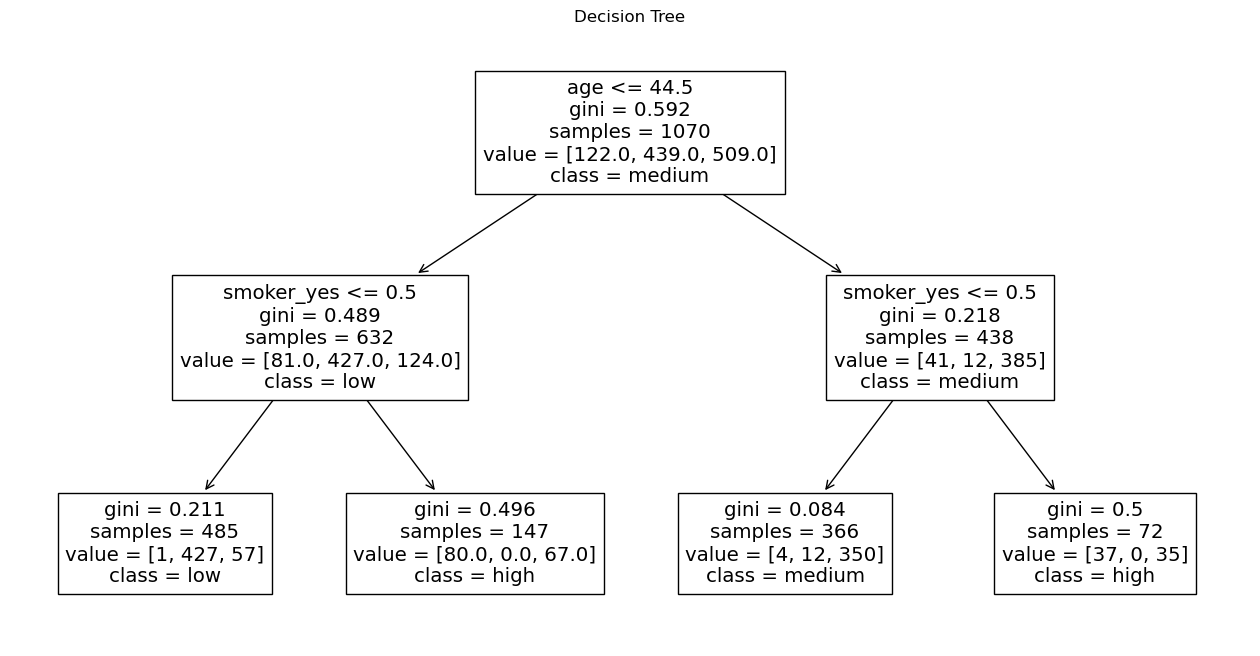

In [15]:
# Training and prediction
model = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=6, random_state=42, max_depth=2)
model.fit(x_train, y_train)
x_0 = {'age': 42, 'bmi': 36, 'region': 'northwest',
         'sex': 'male',
         'smoker': 'no', 'children':2}
x_0 = pd.DataFrame(encode_new_row(x_0, x_train))
print(f"Prediction for given example: {model.predict(x_0)[0]}")

# Visualize the tree
plt.figure(figsize = (16,8))
plot_tree(
    model, 
    feature_names = x_train.columns, 
    class_names = model.classes_
)
plt.title("Decision Tree")
plt.show()

In [83]:
accuracy(y_test['chargeGroup'], model.predict(x_test))

0.8507462686567164